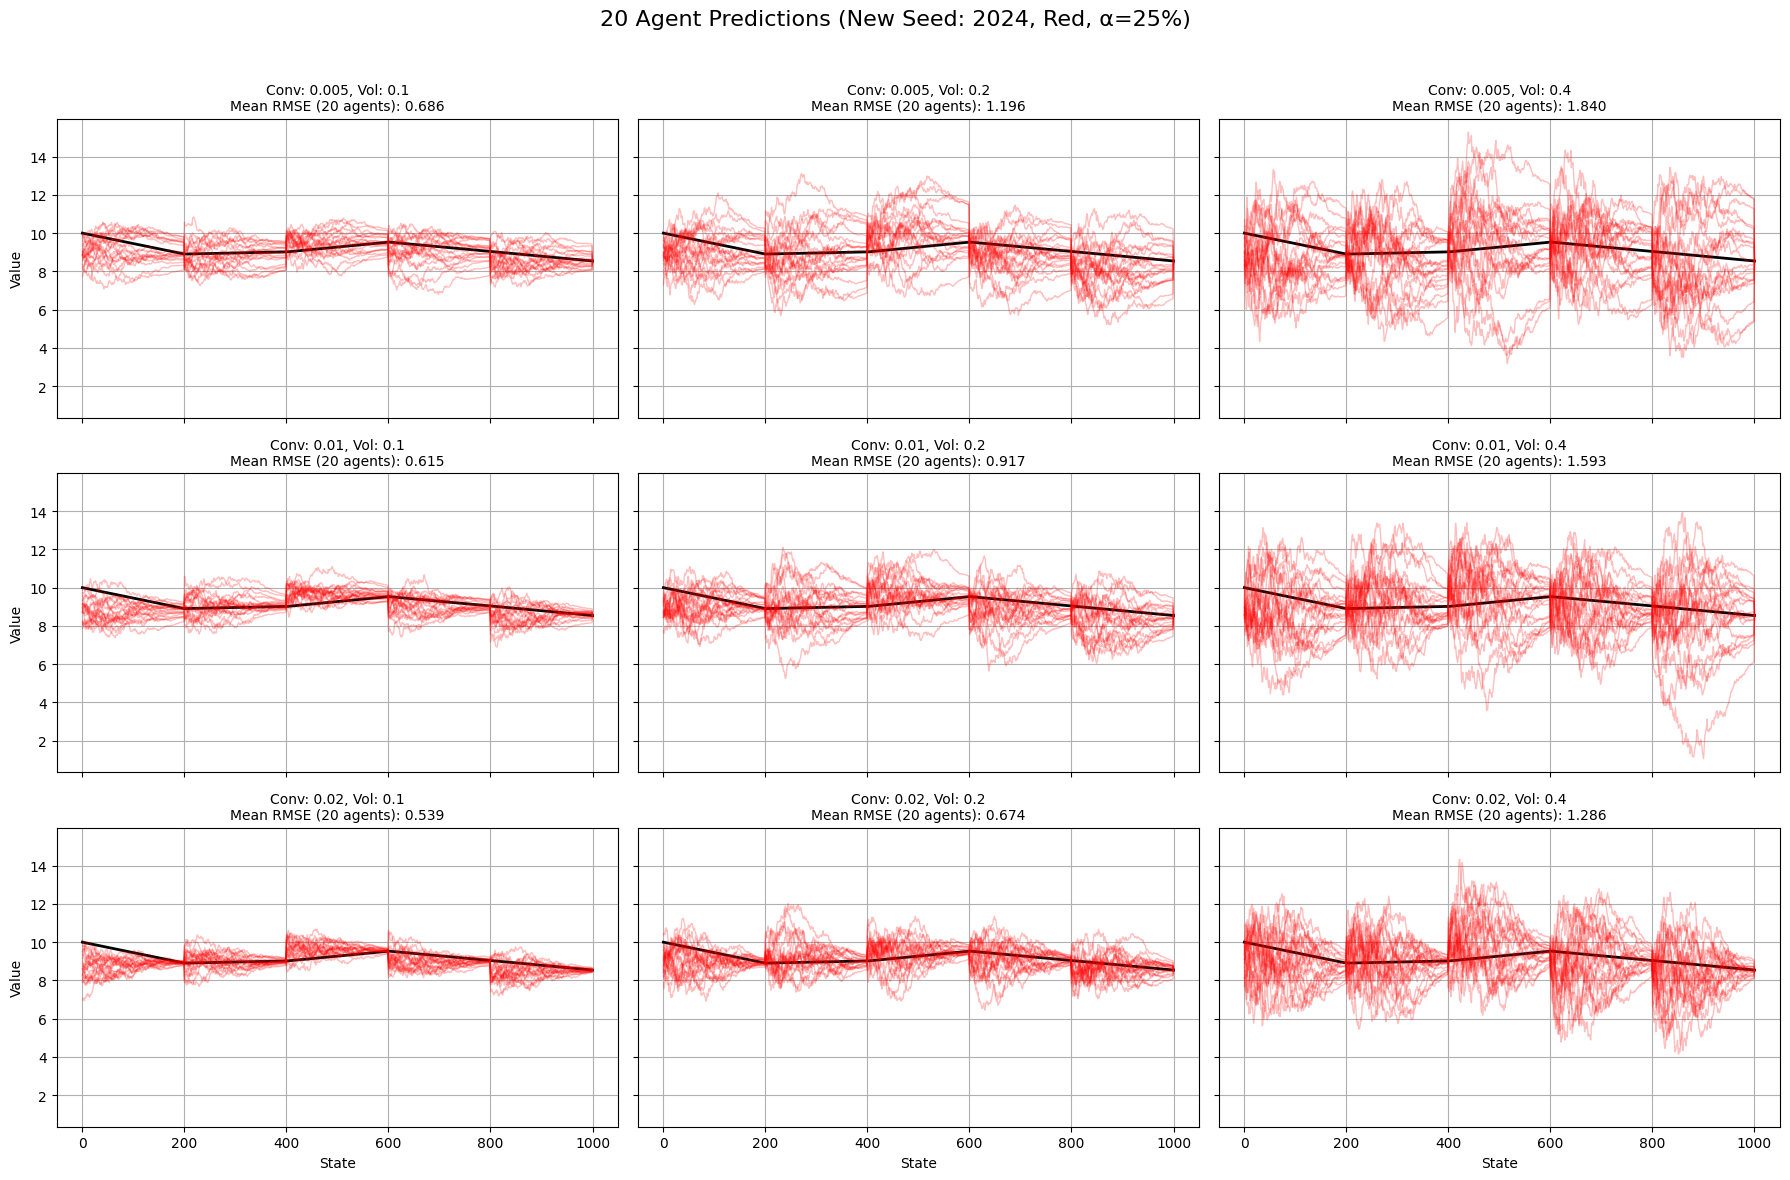

In [19]:
# Full regeneration using a new global RNG seed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Parameters
state_start = 0
state_end = 1000
checkpoint_interval = 200
initial_value = 10
noise_level = 1.0
num_agents = 20

# Create states and checkpoints
states = np.arange(state_start, state_end + 1)
checkpoints = np.arange(0, state_end + 1, checkpoint_interval)

# Grid of convergence strengths and volatilities
convergence_strengths = [0.005, 0.01, 0.02]
volatilities = [0.1, 0.2, 0.4]

# New global RNG seed for full regeneration
global_rng = np.random.default_rng()

# Generate shared true values and path
true_values = [initial_value]
for _ in range(1, len(checkpoints)):
    next_val = true_values[-1] + global_rng.normal(0, noise_level)
    true_values.append(next_val)
true_path = np.interp(states, checkpoints, true_values)

# Estimate std dev of true random value changes
true_diffs = np.diff(true_values)
estimated_std = np.std(true_diffs)

# Create 3x3 subplot
fig, axs = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)

# Generate plots
for i, conv_strength in enumerate(convergence_strengths):
    for j, volatility in enumerate(volatilities):
        ax = axs[i, j]

        # Re-seed each subplot from the global RNG
        local_seed = global_rng.integers(1_000_000)
        local_rng = np.random.default_rng(seed=local_seed)

        # Initialize agent paths
        agent_paths = [[] for _ in range(num_agents)]

        # Build agent paths using shared true values
        for k in range(len(checkpoints) - 1):
            end_val = true_values[k + 1]
            segment_len = checkpoint_interval

            for agent_id in range(num_agents):
                current_pred = local_rng.normal(loc=end_val, scale=estimated_std)

                segment = []
                for step in range(segment_len):
                    t = step / segment_len
                    decay = (1 - t)

                    drift = (end_val - current_pred) * conv_strength
                    noise = local_rng.normal(0, volatility * decay)
                    current_pred += drift + noise

                    segment.append(current_pred)

                agent_paths[agent_id].extend(segment)

        # Add final point
        for agent_id in range(num_agents):
            agent_paths[agent_id].append(true_values[-1])

        # Compute mean RMSE
        mean_rmse = np.mean([
            np.sqrt(mean_squared_error(true_path, path))
            for path in agent_paths
        ])

        # Plot true path
        ax.plot(states, true_path, label="True Random", linewidth=2, color='black')

        # Plot all agents in red with 25% opacity
        for agent_id in range(num_agents):
            ax.plot(states, agent_paths[agent_id], color='red', linewidth=1.0, alpha=0.25)

        ax.set_title(f"Conv: {conv_strength}, Vol: {volatility}\nMean RMSE (20 agents): {mean_rmse:.3f}", fontsize=10)
        ax.grid(True)
        if i == 2:
            ax.set_xlabel("State")
        if j == 0:
            ax.set_ylabel("Value")

plt.suptitle("20 Agent Predictions (New Seed: 2024, Red, α=25%)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [20]:
import functools
from pettingzoo import ParallelEnv
from gymnasium import spaces
from typing import Callable, List, Dict, Tuple, Any
import numpy as np
import numpy.typing as npt
from helpers.Paths import BSMPathExtended, MeanRevertingPathFollower, sliding_window_edge_pad

class TradeFlowPriceSimulation(ParallelEnv[int, spaces.Dict, spaces.MultiDiscrete]):
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def action_space(self, agent):
        return self.action_spaces[agent]

    def render(self):
        return None
    
    def close(self):
        return None
    
    def _get_infos(self):
        return {agent_id: {} for agent_id in self.agents}
    
    def _get_terminated(self, is_terminated: bool):
        retval: dict[int, bool] = {}
        for agent_id in self.agents:
            retval[agent_id] = is_terminated
        return retval
    
    def _get_truncated(self):
        retval: dict[int, False] = {}
        for agent_id in self.agents:
            retval[agent_id] = False
        return retval
    
    def _get_true_dividends(self):
        true_values = [self.initial_dividend]
        for _ in range(1, len(self.dividend_dates)):
            next_val = true_values[-1] + self.rng.normal(0, self.dividend_volatility)
            true_values.append(next_val)
            pass
        return true_values
    
    def _get_dividend_estimate(self):
        return [x + self.rng.normal(0.0, self.agent_dividend_estimate_volatility) for x in self.dividend_true_values]
    
    def __init__(self, agent_count: int):
        super().__init__()
        self.render_mode = None
        self.metadata = {
            "render_modes": [],
            "name": "ParallelTradingEnv",
            "is_parallelizable": True,
        }
        self.agents = list(range(agent_count))
        self.possible_agents = list(range(agent_count))
        self.rng = np.random.default_rng()
        
        self.current_step = 0
        self.total_steps = 1_000
        self.dividend_interval = 200
        self.max_position = 20
        self.price_move_per_net_volume = 0.01
        self.initial_dividend = 10.0
        self.dividend_dates: set[int] = set([x for x in np.arange(0, self.total_steps + 1, self.dividend_interval)])
        self.dividend_volatility = 2.0
        self.agent_dividend_estimate_volatility = self.dividend_volatility
        self.initial_stock_price = 50.0
        self.margin_interest_rate = 0.1
        
        self.observation_spaces = {agent_id: spaces.Dict({
            "current_price": spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            "position": spaces.Box(low=-self.max_position, high=self.max_position, shape=(1,), dtype=np.int32),
            "steps_to_dividend": spaces.Box(low=0, high=100, shape=(1,), dtype=np.int32),
            "forecasted_dividend": spaces.Box(low=0, high=10, shape=(1,), dtype=np.float32),
            "cash_balance": spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
        }) for agent_id in self.agents}
        self.action_spaces = {agent_id: spaces.MultiDiscrete([
            3, # Action, 0=BUY, 1=SELL, 2=NOTHING
            5, # Quantity (1-10)
        ]) for agent_id in self.agents}

        self.reset()
        pass
    
    def _get_obs(self):
        obs = {}
        for agent_id in self.agents:
            if self.current_step != self.total_steps:
                forecasted_dividends = self.agent_dividend_estimates[agent_id][self.current_step // self.dividend_interval + 1]
            else:
                forecasted_dividends = self.agent_dividend_estimates[agent_id][-1]
            
            obs[agent_id] = {
                "current_price": np.array([self.current_stock_price], dtype=np.float32),
                "position": np.array([self.agent_current_positions[agent_id]["STOCK"]], dtype=np.int32),
                "steps_to_dividend": np.array([self.dividend_interval - self.current_step % self.dividend_interval], dtype=np.int32),
                "forecasted_dividend": np.array([forecasted_dividends], dtype=np.float32),
                "cash_balance": np.array([self.agent_current_positions[agent_id]["CASH"] + self.agent_current_positions[agent_id]["DIVIDENDS"]], dtype=np.float32),
            }
            pass
        return obs
    
    def step(self, actions):
        self.agent_previous_positions = { agent_id: self.agent_current_positions[agent_id].copy() for agent_id in self.agents }
        
        if self.current_step in self.dividend_dates:
            for agent_id, positions in self.agent_current_positions.items():
                positions["DIVIDENDS"] += positions["STOCK"] * self.dividend_true_values[self.current_step % self.dividend_interval]
                pass
            pass
        
        buy_volume = 0
        sell_volume = 0
        for agent_id, action in actions.items():
            action_tuple = tuple(map((lambda x: x), action))
            match action_tuple:
                case (1, quantity):
                    # BUY
                    quantity += 1
                    if self.agent_current_positions[agent_id]["STOCK"] + quantity <= self.max_position:
                        buy_volume += quantity
                        pass
                    pass
                case (2, quantity):
                    quantity += 1
                    if self.agent_current_positions[agent_id]["STOCK"] - quantity >= -self.max_position:
                        sell_volume += quantity
                        pass
                    pass
                case (3, _):
                    # DO NOTHING
                    pass
                case (_, _):
                    # Default case, do nothing
                    pass
            pass

        previous_stock_price = self.current_stock_price
        updated_stock_price = round(self.current_stock_price + (buy_volume - sell_volume) * self.price_move_per_net_volume + self.rng.normal(0, 0.05), 2)
        
        hi_stock_price = max(previous_stock_price, updated_stock_price)
        lo_stock_price = min(previous_stock_price, updated_stock_price)
        
        for agent_id, action in actions.items():
            action_tuple = tuple(map((lambda x: x), action))
            trade_distribution = round(self.rng.uniform(low=lo_stock_price, high=hi_stock_price + 0.01), 2)
            
            cash = self.agent_current_positions[agent_id]["CASH"]
            if cash < 0:
                self.agent_current_positions[agent_id]["CASH"] *= (1 + self.margin_interest_rate / self.total_steps)
            
            match action_tuple:
                case (1, quantity):
                    # BUY
                    quantity += 1
                    if self.agent_current_positions[agent_id]["STOCK"] + quantity <= self.max_position:
                        self.agent_current_positions[agent_id]["STOCK"] += quantity
                        self.agent_current_positions[agent_id]["CASH"] -= quantity * trade_distribution
                        pass
                    pass
                case (2, quantity):
                    quantity += 1
                    if self.agent_current_positions[agent_id]["STOCK"] - quantity >= -self.max_position:
                        self.agent_current_positions[agent_id]["STOCK"] -= quantity
                        self.agent_current_positions[agent_id]["CASH"] += quantity * trade_distribution
                        pass
                    pass
                case (3, _):
                    # DO NOTHING
                    pass
                case (_, _):
                    # Default case, do nothing
                    pass
            pass
        self.current_stock_price = updated_stock_price
        
        rewards: dict[int, float] = {}
        for agent_id in self.agents:
            delta_dividends = self.agent_current_positions[agent_id]["DIVIDENDS"] - self.agent_previous_positions[agent_id]["DIVIDENDS"]
            delta_pnl = (
                (self.agent_current_positions[agent_id]["CASH"] - self.agent_previous_positions[agent_id]["CASH"]) + 
                (self.agent_current_positions[agent_id]["STOCK"] - self.agent_previous_positions[agent_id]["STOCK"]) * self.current_stock_price
            )
            reward = delta_dividends + delta_pnl
            rewards[agent_id] = reward # np.clip(reward, -10.0, 10.0)
            pass
        
        terminated = False
        self.current_step += 1
        if self.current_step >= self.total_steps:
            terminated = True

        obs = self._get_obs()
        infos = self._get_infos()
        terminateds = self._get_terminated(terminated)
        truncateds = self._get_truncated()
        
        if terminated:
            self.agents = []
        
        return obs, rewards, terminateds, truncateds, infos
    
    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.current_step = 0
        self.agent_current_positions = { agent_id: {
            "CASH": 0.0,
            "STOCK": 0.0,
            "DIVIDENDS": 0.0
        } for agent_id in self.agents }
        self.agent_previous_positions = { agent_id: self.agent_current_positions[agent_id].copy() for agent_id in self.agents }
        self.dividend_true_values = self._get_true_dividends()
        self.agent_dividend_estimates = { agent_id: self._get_dividend_estimate() for agent_id in self.agents }
        self.current_stock_price = self.initial_stock_price
        
        obs = self._get_obs()
        infos = self._get_infos()
        return obs, infos        
    pass    


In [21]:
env = TradeFlowPriceSimulation(agent_count=20)
observations, infos = env.reset()

done = False
while not done:
    actions = { agent: env.action_space(agent).sample() for agent in env.agents }
    observations, rewards, terminated, truncations, infos = env.step(actions)
    done = any(terminated.values())
env.close()

In [22]:
from pettingzoo.test import parallel_api_test
env = TradeFlowPriceSimulation(agent_count=20)
parallel_api_test(env, num_cycles=1000)
env.close()

Passed Parallel API test


In [23]:
AGENT_COUNT = 50
TOTAL_TIMESTEPS = 1_000_000
PREFIX = "rl01"

In [24]:
import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

parallel_env = TradeFlowPriceSimulation(agent_count=AGENT_COUNT)
parallel_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
parallel_env = ss.concat_vec_envs_v1(
    parallel_env, num_vec_envs=1, num_cpus=1, base_class="stable_baselines3"
)

model = PPO(
    "MultiInputPolicy",
    parallel_env,
    verbose=0,
    tensorboard_log=f"./{PREFIX}/tensorboard_logs/",
    device="cpu",
    policy_kwargs=dict(net_arch=[64, 64]),
    # policy_kwargs=dict(
    #     net_arch=dict(pi=[128, 128], vf=[128, 128])
    # ),
    learning_rate=1e-4
)

checkpoint_callback = CheckpointCallback(
    save_freq=10_000, save_path=f"./{PREFIX}/checkpoints/", name_prefix="rl_model"
)

model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[checkpoint_callback])

model.save(f"./{PREFIX}/model_final")

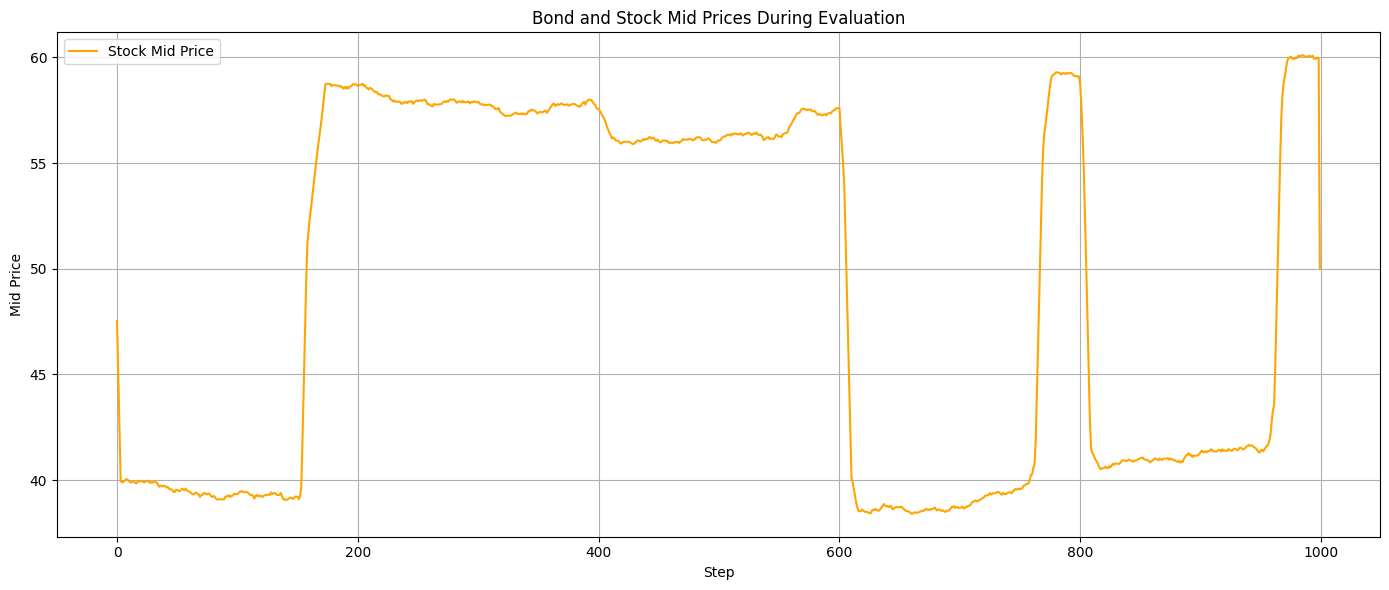

In [25]:
import matplotlib.pyplot as plt

# Paths
MODEL_PATH = f"./{PREFIX}/model_final"

# 1. Load environment and wrap it exactly the same way
eval_env = TradeFlowPriceSimulation(agent_count=AGENT_COUNT)
eval_env = ss.pettingzoo_env_to_vec_env_v1(eval_env)
eval_env = ss.concat_vec_envs_v1(
    eval_env, num_vec_envs=1, num_cpus=1, base_class="stable_baselines3"
)

# 2. Load trained model
# model = PPO.load(MODEL_PATH, env=eval_env)

# 3. Reset environment
obs = eval_env.reset()

# 4. Storage for plotting
stock_midpoints = []
portfolio_values = {agent_id: [] for agent_id in range(AGENT_COUNT)}

done = False

# 5. Run one full evaluation episode
while not done:
    # 5a. Predict actions
    action, _states = model.predict(obs, deterministic=True)
        
    # 5b. Step environment
    obs, rewards, dones, infos = eval_env.step(action)

    # 5c. Mid price extraction from observation
    # observations are a list with 1 env -> list of dicts for each agent
    stock_midpoint = obs["current_price"][0]
    stock_midpoints.append(stock_midpoint)    

    done = dones[0]  # vectorized env with 1 env, so index 0

# 7. Plotting results

# 7a. Mid price plots
plt.figure(figsize=(14,6))
plt.plot(stock_midpoints, label="Stock Mid Price", color="orange")
plt.xlabel("Step")
plt.ylabel("Mid Price")
plt.title("Bond and Stock Mid Prices During Evaluation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()